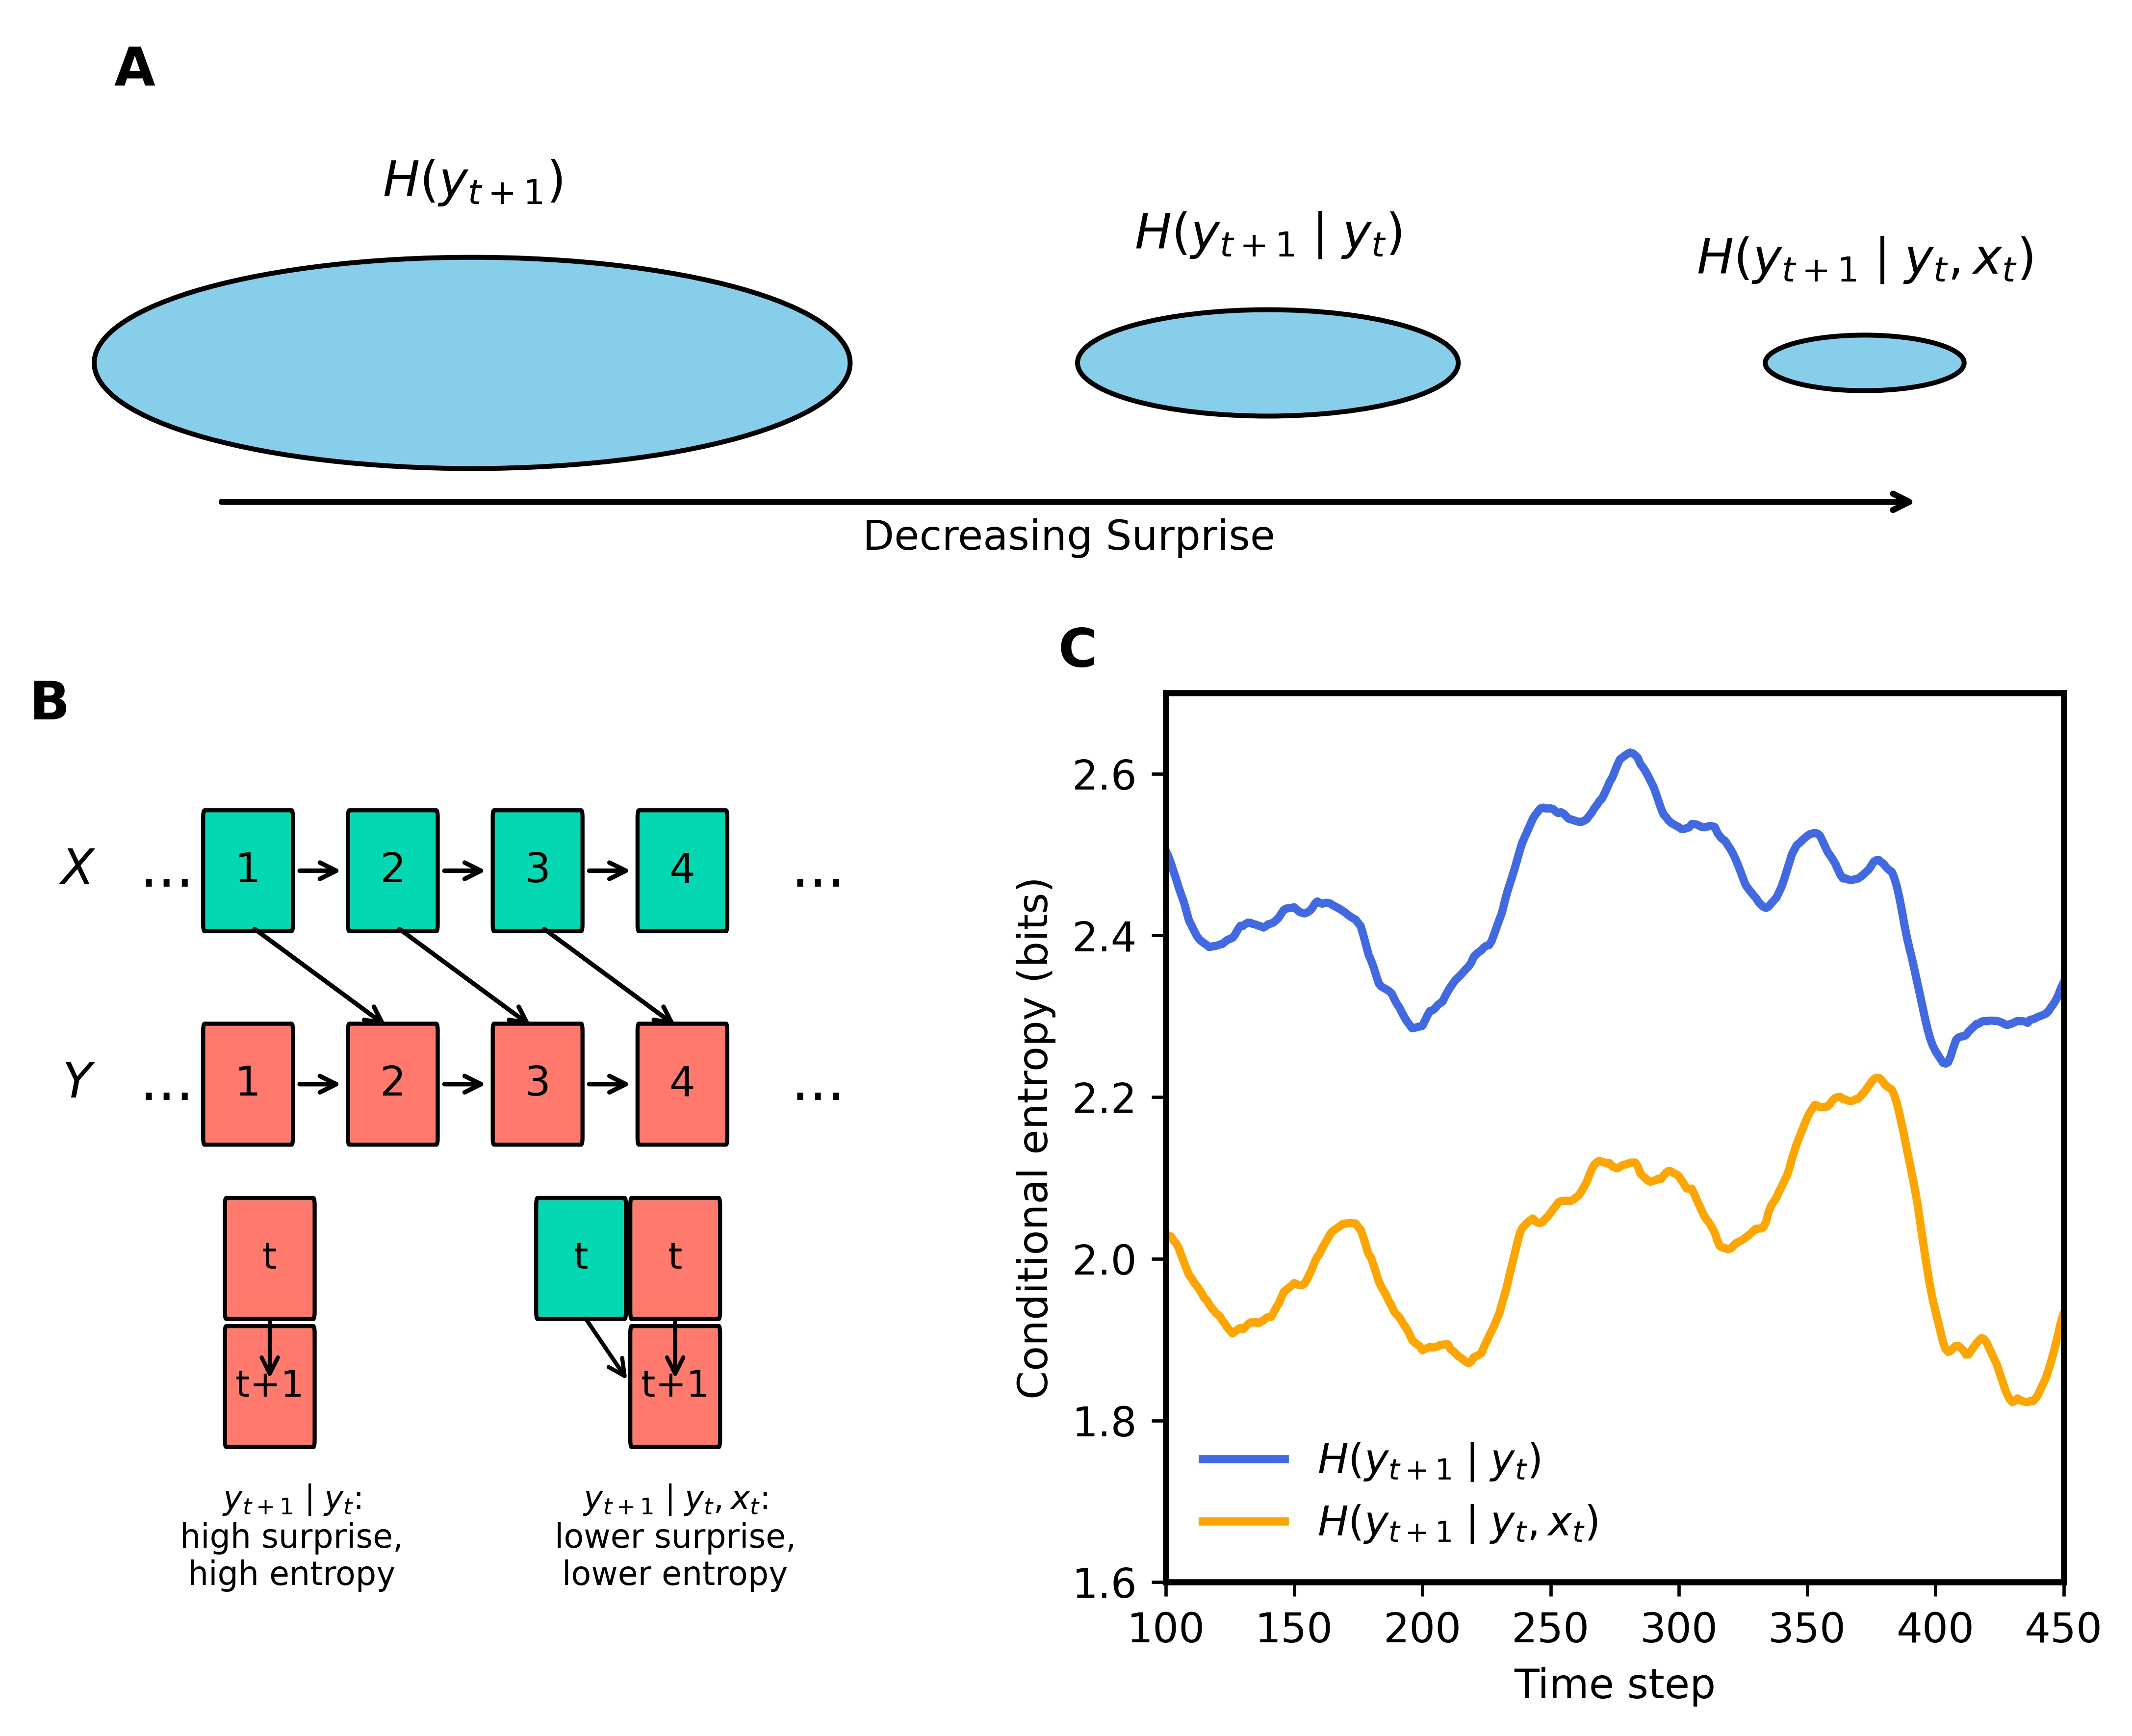

In [65]:
import matplotlib.patches as patches
import numpy as np
import matplotlib.pyplot as plt

# Set random seed for reproducibility
np.random.seed(0)

# 1. Simulate two variables where X drives Y
N = 1000
sigma_x = 1.0
sigma_y = 1.0
X = np.zeros(N)
Y = np.zeros(N)
for t in range(1, N):
    X[t] = 0.8 * X[t - 1] + np.random.normal(0, sigma_x)
    Y[t] = 0.5 * Y[t - 1] + 0.7 * X[t - 1] + np.random.normal(0, sigma_y)

# 2. Sliding-window conditional entropies (bits)
window = 50
times  = np.arange(window, N - 1)
H_y, H_xy = [], []
for t in times:
    idx = slice(t - window, t)
    Y_p = Y[idx]; Y_f = Y[idx.start+1: idx.stop+1]; X_p = X[idx]

    resid1 = Y_f - np.vstack([np.ones_like(Y_p), Y_p]).T @ np.linalg.lstsq(
        np.vstack([np.ones_like(Y_p), Y_p]).T, Y_f, rcond=None)[0]
    resid2 = Y_f - np.vstack([np.ones_like(Y_p), Y_p, X_p]).T @ np.linalg.lstsq(
        np.vstack([np.ones_like(Y_p), Y_p, X_p]).T, Y_f, rcond=None)[0]

    H_y.append(0.5 * np.log2(2*np.pi*np.e*np.var(resid1, ddof=1)))
    H_xy.append(0.5 * np.log2(2*np.pi*np.e*np.var(resid2, ddof=1)))

H_y, H_xy = map(np.array, (H_y, H_xy))
H_uncond  = 0.5 * np.log2(2*np.pi*np.e*np.var(Y[1:], ddof=1))
H_y  = np.convolve(H_y,  np.ones(20)/20, mode='same')
H_xy = np.convolve(H_xy, np.ones(20)/20, mode='same')

# ------------------------------------------------------------------ figure
fig = plt.figure(figsize=(7.2, 6), dpi=600)
gs  = fig.add_gridspec(2, 2, height_ratios=[1, 1.6])

# -------- Panel A --------------------------------------------------------
ax_top = fig.add_subplot(gs[0, :]); ax_top.axis('off')
ax_top.text(0.02, 0.9, 'A', fontsize=13, fontweight='bold', transform=ax_top.transAxes)
x_loc = [0.2, 0.6, 0.9]
vals  = [H_uncond, H_y.mean(), H_xy.mean()]
r_min, r_max = 0.05, 0.19
v_min, v_max = min(vals), max(vals)
radii = [r_min + (v-v_min)/(v_max-v_min)*(r_max-r_min) for v in vals]
labels = [r'$H(y_{t+1})$', r'$H(y_{t+1}\mid y_t)$', r'$H(y_{t+1}\mid y_t,x_t)$']
for x,r,lab in zip(x_loc, radii, labels):
    ax_top.add_patch(plt.Circle((x,0.4), r, fc='skyblue', ec='k', lw=1.2))
    ax_top.text(x, 0.45+r+0.04, lab, ha='center', va='bottom', fontsize=12)
ax_top.annotate('', xy=(0.93,0.15), xytext=(0.07,0.15),
                arrowprops=dict(arrowstyle='->', lw=1.5))
ax_top.text(0.5,0.12,'Decreasing Surprise', ha='center', va='top', fontsize=10)
ax_top.set(xlim=(0,1), ylim=(0,1))

# -------- Panel B --------------------------------------------------------
ax_ts = fig.add_subplot(gs[1,0]); ax_ts.axis('off')
ax_ts.text(-0.05,0.97,'B', fontsize=13, fontweight='bold', transform=ax_ts.transAxes)

box_w, box_h = 0.6, 0.15
yX, yY = 0.75, 0.45
xs = np.arange(0,4)
color_X, color_Y = '#04d8b2', '#FF796C'

def row(y, fc, label):
    for i,x in enumerate(xs):
        ax_ts.add_patch(patches.FancyBboxPatch((x-box_w/2,y-box_h/2), box_w, box_h,
                                               boxstyle="round,pad=0.01", ec='k', fc=fc))
        ax_ts.text(x,y,str(i+1), ha='center', va='center', fontsize=10)
        if i<xs[-1]:
            ax_ts.annotate('', xy=(x+1-box_w/2,y), xytext=(x+box_w/2,y),
                           arrowprops=dict(arrowstyle='->', lw=1.1))
    ax_ts.text(-0.75,y,'...',fontsize=14,va='center')
    ax_ts.text(3.75,y,'...',fontsize=14,va='center')
    ax_ts.text(-1.05,y,label,ha='right',va='center',fontsize=12)

row(yX,color_X,r'$X$'); row(yY,color_Y,r'$Y$')
for x in xs[:-1]:
    ax_ts.annotate('', xy=(x+1,yY+box_h/2), xytext=(x,yX-box_h/2),
                   arrowprops=dict(arrowstyle='->', lw=1.1))

# -- mini-graphs ---------------------------------------------------------
mini_w, mini_h = 0.6, 0.15
y_mini = -0.05

# Left mini: Y_t -> Y_{t+1}
x_left = -0.8

# y_t
ax_ts.add_patch(patches.FancyBboxPatch((x_left+mini_w+0.05, y_mini+mini_h+0.03),
                                       mini_w, mini_h, boxstyle="round,pad=0.01",
                                       ec='k', fc=color_Y))
ax_ts.text(x_left+mini_w+0.05+mini_w/2, y_mini+mini_h+0.03+mini_h/2, 't',
           ha='center', va='center', fontsize=9)
# y_{t+1}
ax_ts.add_patch(patches.FancyBboxPatch((x_left+mini_w+0.05, y_mini), mini_w, mini_h,
                                       boxstyle="round,pad=0.01", ec='k', fc=color_Y))
ax_ts.text(x_left+mini_w+0.05+mini_w/2, y_mini+mini_h/2, 't+1',
           ha='center', va='center', fontsize=9)

ax_ts.annotate('', xy=(x_left+mini_w+0.05+mini_w/2, y_mini+mini_h/2),
               xytext=(x_left+mini_w+0.05+mini_w/2, y_mini+mini_h+0.03),
               arrowprops=dict(arrowstyle='->', lw=1.0))

ax_ts.text(
    x_left + 0.5 + mini_w,
    y_mini - 0.06,
    r'$y_{t+1}\mid y_t$:' '\n'
    'high surprise,' '\n'
    'high entropy',
    ha='center', va='top', fontsize=8)

# Right mini: X_t & Y_t -> Y_{t+1}
x_right = 2
# X_t
ax_ts.add_patch(patches.FancyBboxPatch((x_right, y_mini+mini_h+0.03), mini_w, mini_h,
                                       boxstyle="round,pad=0.01", ec='k', fc=color_X))
ax_ts.text(x_right+mini_w/2, y_mini+mini_h+0.03+mini_h/2, 't',
           ha='center', va='center', fontsize=9)
# y_t
ax_ts.add_patch(patches.FancyBboxPatch((x_right+mini_w+0.05, y_mini+mini_h+0.03),
                                       mini_w, mini_h, boxstyle="round,pad=0.01",
                                       ec='k', fc=color_Y))
ax_ts.text(x_right+mini_w+0.05+mini_w/2, y_mini+mini_h+0.03+mini_h/2, 't',
           ha='center', va='center', fontsize=9)
# y_{t+1}
ax_ts.add_patch(patches.FancyBboxPatch((x_right+mini_w+0.05, y_mini), mini_w, mini_h,
                                       boxstyle="round,pad=0.01", ec='k', fc=color_Y))
ax_ts.text(x_right+mini_w+0.05+mini_w/2, y_mini+mini_h/2, 't+1',
           ha='center', va='center', fontsize=9)
# arrows
ax_ts.annotate('', xy=(x_right+mini_w+0.05+mini_w/2, y_mini+mini_h/2),
               xytext=(x_right+mini_w+0.05+mini_w/2, y_mini+mini_h+0.03),
               arrowprops=dict(arrowstyle='->', lw=1.0))
ax_ts.annotate('', xy=(x_right+mini_w+0.05, y_mini+mini_h/2),
               xytext=(x_right+mini_w/2, y_mini+mini_h+0.03),
               arrowprops=dict(arrowstyle='->', lw=1.0))

ax_ts.text(
    x_right + mini_w + 0.05 + mini_w / 2,
    y_mini - 0.06,
    r'$y_{t+1}\mid y_t,x_t$:' '\n'
    'lower surprise,' '\n'
    'lower entropy',
    ha='center', va='top', fontsize=8)

ax_ts.set(xlim=(-1.2,5), ylim=(-0.25,1))

# -------- Panel C -------------------------------------------------------
ax_e = fig.add_subplot(gs[1,1])
ax_e.text(-0.12,1.03,'C', fontsize=13, fontweight='bold', transform=ax_e.transAxes)
ax_e.plot(times, H_y,  label=r'$H(y_{t+1}\mid y_t)$',  color='royalblue', lw=2)
ax_e.plot(times, H_xy, label=r'$H(y_{t+1}\mid y_t,x_t)$', color='orange',  lw=2)
ax_e.set_xlim(times[0]+50, times[0]+400); ax_e.set_ylim(1.6,2.7)
ax_e.set_xlabel('Time step'); ax_e.set_ylabel('Conditional entropy (bits)')
ax_e.legend(frameon=False)
for sp in ['top','bottom','left','right']:
    ax_e.spines[sp].set_linewidth(1.5)

fig.tight_layout()
plt.show()


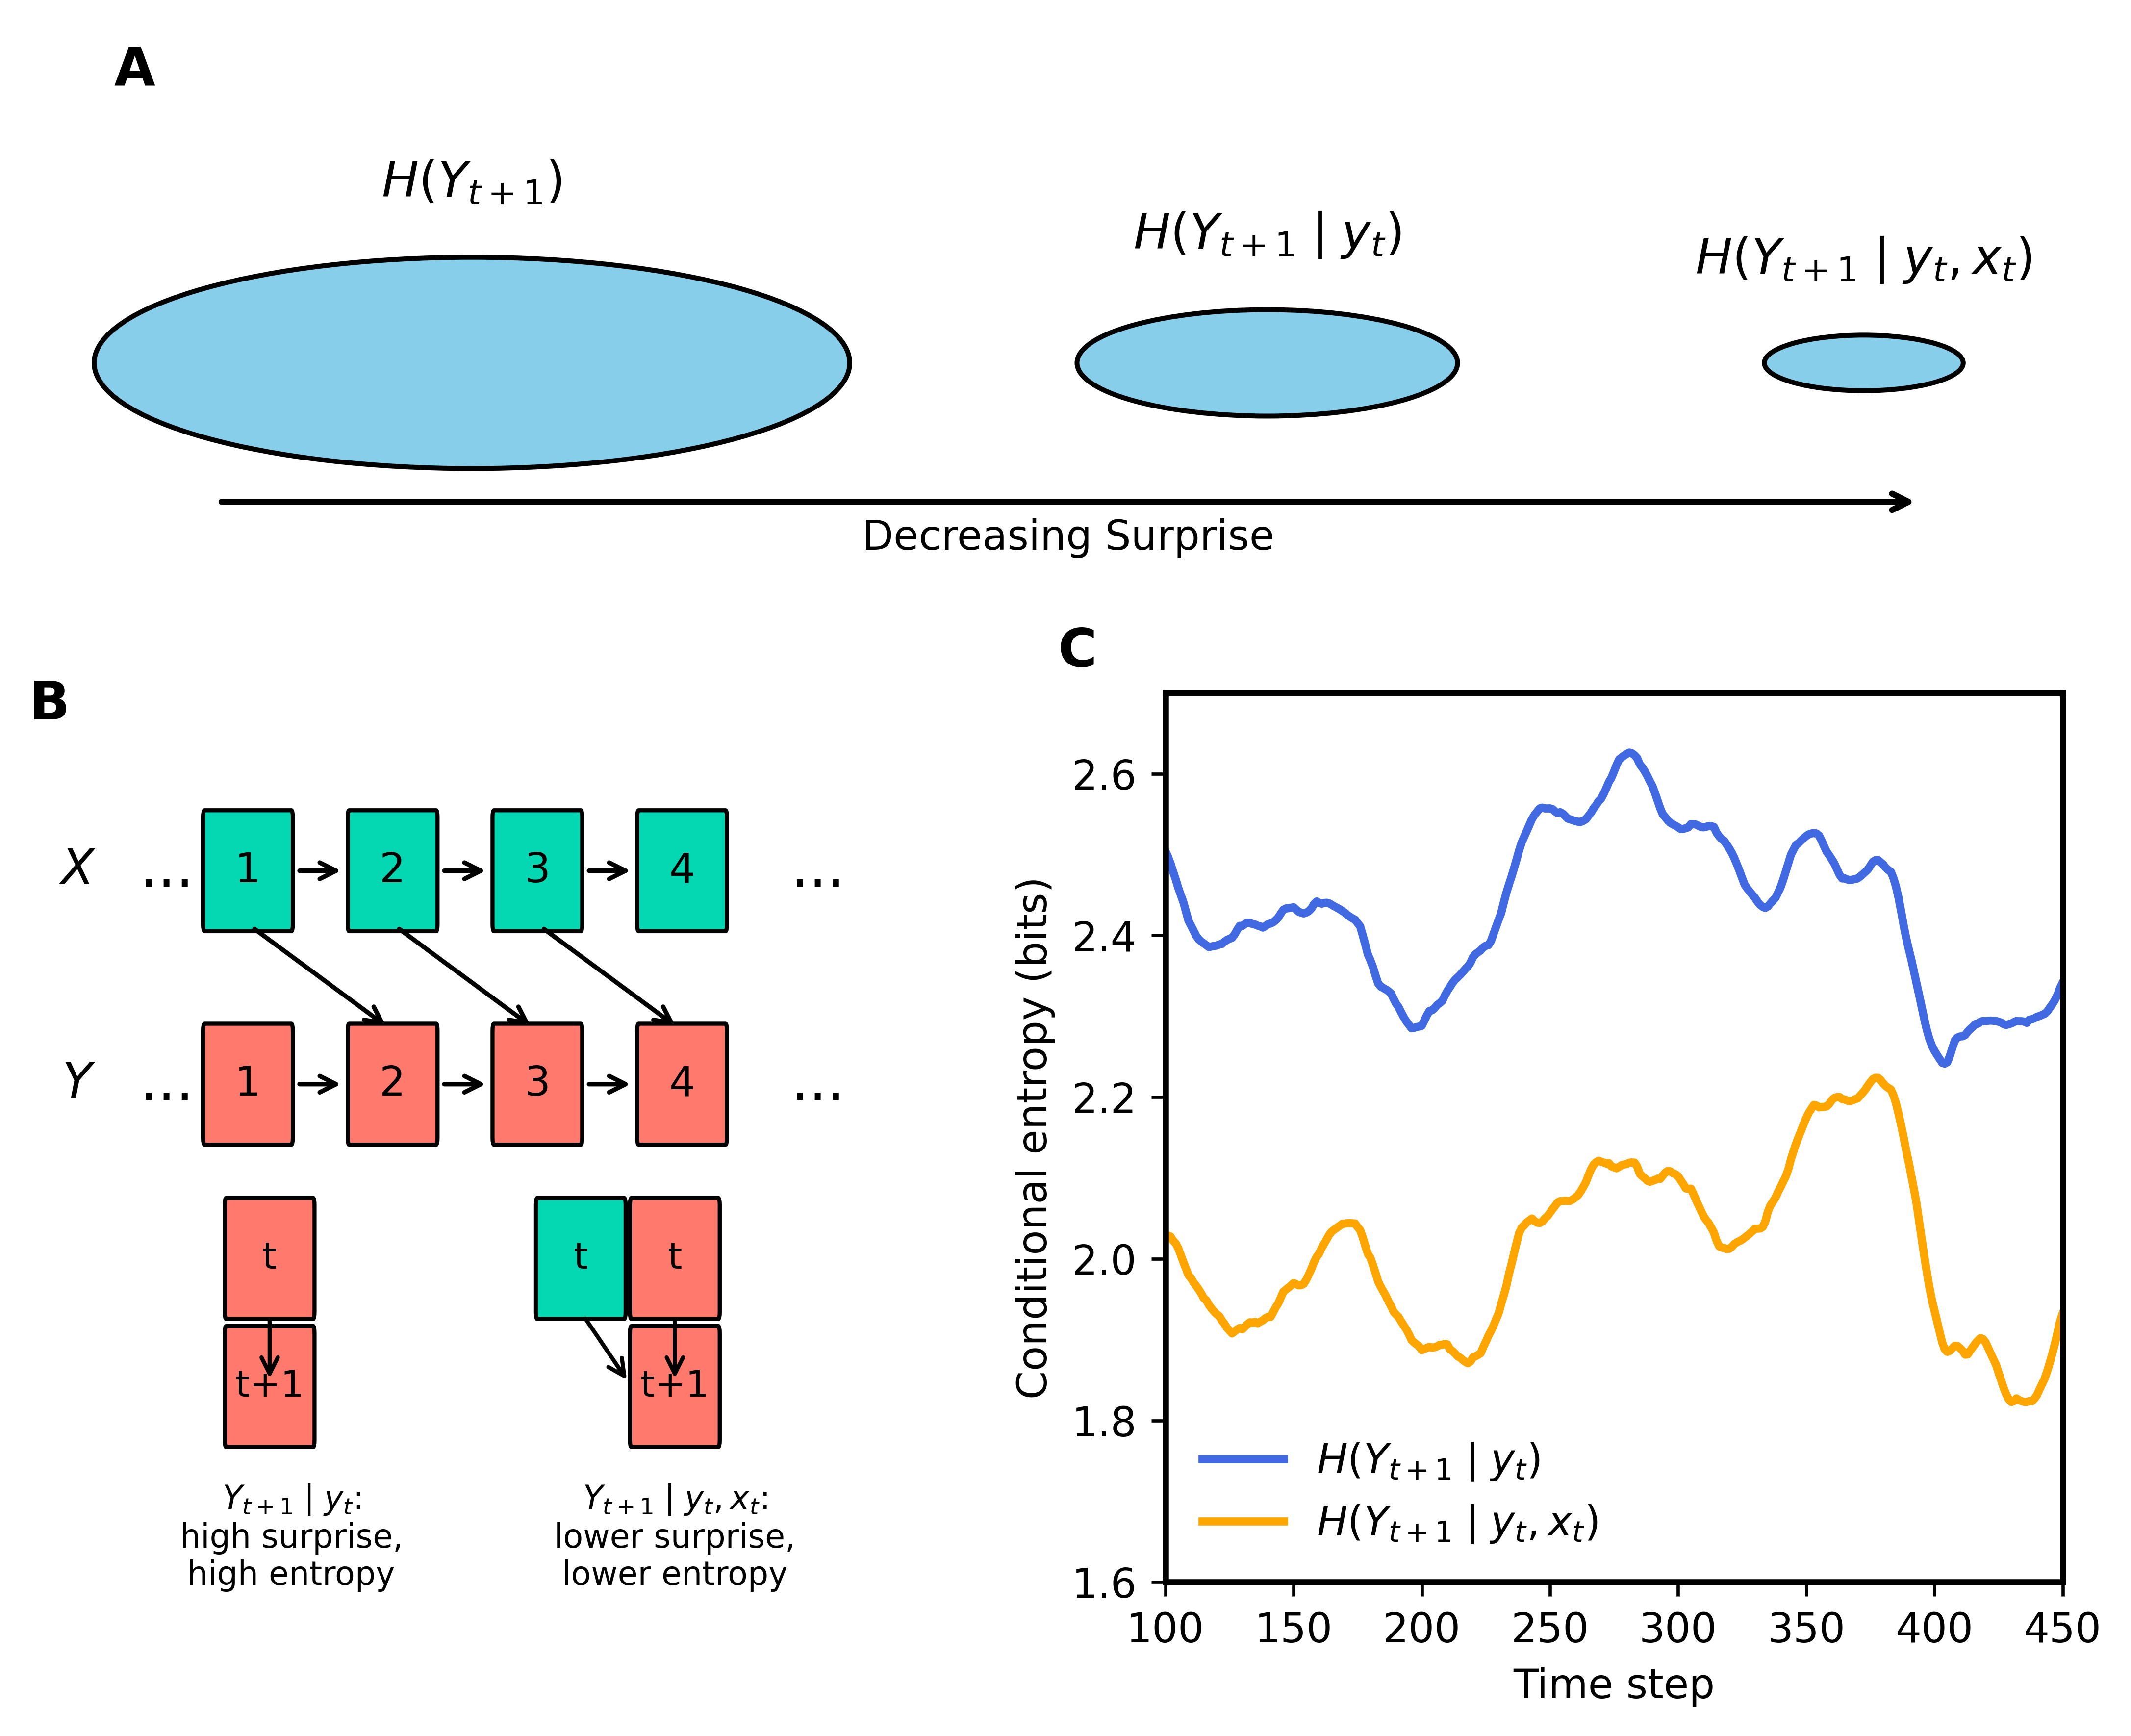

In [64]:
import matplotlib.patches as patches
import numpy as np
import matplotlib.pyplot as plt

# Set random seed for reproducibility
np.random.seed(0)

# 1. Simulate two variables where X drives Y
N = 1000
sigma_x = 1.0
sigma_y = 1.0
X = np.zeros(N)
Y = np.zeros(N)
for t in range(1, N):
    X[t] = 0.8 * X[t - 1] + np.random.normal(0, sigma_x)
    Y[t] = 0.5 * Y[t - 1] + 0.7 * X[t - 1] + np.random.normal(0, sigma_y)

# 2. Sliding-window conditional entropies (bits)
window = 50
times  = np.arange(window, N - 1)
H_y, H_xy = [], []
for t in times:
    idx = slice(t - window, t)
    Y_p = Y[idx]; Y_f = Y[idx.start+1: idx.stop+1]; X_p = X[idx]

    resid1 = Y_f - np.vstack([np.ones_like(Y_p), Y_p]).T @ np.linalg.lstsq(
        np.vstack([np.ones_like(Y_p), Y_p]).T, Y_f, rcond=None)[0]
    resid2 = Y_f - np.vstack([np.ones_like(Y_p), Y_p, X_p]).T @ np.linalg.lstsq(
        np.vstack([np.ones_like(Y_p), Y_p, X_p]).T, Y_f, rcond=None)[0]

    H_y.append(0.5 * np.log2(2*np.pi*np.e*np.var(resid1, ddof=1)))
    H_xy.append(0.5 * np.log2(2*np.pi*np.e*np.var(resid2, ddof=1)))

H_y, H_xy = map(np.array, (H_y, H_xy))
H_uncond  = 0.5 * np.log2(2*np.pi*np.e*np.var(Y[1:], ddof=1))
H_y  = np.convolve(H_y,  np.ones(20)/20, mode='same')
H_xy = np.convolve(H_xy, np.ones(20)/20, mode='same')

# ------------------------------------------------------------------ figure
fig = plt.figure(figsize=(7.2, 6), dpi=600)
gs  = fig.add_gridspec(2, 2, height_ratios=[1, 1.6])

# -------- Panel A --------------------------------------------------------
ax_top = fig.add_subplot(gs[0, :]); ax_top.axis('off')
ax_top.text(0.02, 0.9, 'A', fontsize=13, fontweight='bold', transform=ax_top.transAxes)
x_loc = [0.2, 0.6, 0.9]
vals  = [H_uncond, H_y.mean(), H_xy.mean()]
r_min, r_max = 0.05, 0.19
v_min, v_max = min(vals), max(vals)
radii = [r_min + (v-v_min)/(v_max-v_min)*(r_max-r_min) for v in vals]
labels = [r'$H(Y_{t+1})$', r'$H(Y_{t+1}\mid y_t)$', r'$H(Y_{t+1}\mid y_t,x_t)$']
for x,r,lab in zip(x_loc, radii, labels):
    ax_top.add_patch(plt.Circle((x,0.4), r, fc='skyblue', ec='k', lw=1.2))
    ax_top.text(x, 0.45+r+0.04, lab, ha='center', va='bottom', fontsize=12)
ax_top.annotate('', xy=(0.93,0.15), xytext=(0.07,0.15),
                arrowprops=dict(arrowstyle='->', lw=1.5))
ax_top.text(0.5,0.12,'Decreasing Surprise', ha='center', va='top', fontsize=10)
ax_top.set(xlim=(0,1), ylim=(0,1))

# -------- Panel B --------------------------------------------------------
ax_ts = fig.add_subplot(gs[1,0]); ax_ts.axis('off')
ax_ts.text(-0.05,0.97,'B', fontsize=13, fontweight='bold', transform=ax_ts.transAxes)

box_w, box_h = 0.6, 0.15
yX, yY = 0.75, 0.45
xs = np.arange(0,4)
color_X, color_Y = '#04d8b2', '#FF796C'

def row(y, fc, label):
    for i,x in enumerate(xs):
        ax_ts.add_patch(patches.FancyBboxPatch((x-box_w/2,y-box_h/2), box_w, box_h,
                                               boxstyle="round,pad=0.01", ec='k', fc=fc))
        ax_ts.text(x,y,str(i+1), ha='center', va='center', fontsize=10)
        if i<xs[-1]:
            ax_ts.annotate('', xy=(x+1-box_w/2,y), xytext=(x+box_w/2,y),
                           arrowprops=dict(arrowstyle='->', lw=1.1))
    ax_ts.text(-0.75,y,'...',fontsize=14,va='center')
    ax_ts.text(3.75,y,'...',fontsize=14,va='center')
    ax_ts.text(-1.05,y,label,ha='right',va='center',fontsize=12)

row(yX,color_X,r'$X$'); row(yY,color_Y,r'$Y$')
for x in xs[:-1]:
    ax_ts.annotate('', xy=(x+1,yY+box_h/2), xytext=(x,yX-box_h/2),
                   arrowprops=dict(arrowstyle='->', lw=1.1))

# -- mini-graphs ---------------------------------------------------------
mini_w, mini_h = 0.6, 0.15
y_mini = -0.05

# Left mini: Y_t -> Y_{t+1}
x_left = -0.8
# for i,label in enumerate(['t','t+1']):
#     ax_ts.add_patch(patches.FancyBboxPatch((x_left + i*(mini_w+0.5), y_mini),
#                                            mini_w, mini_h, boxstyle="round,pad=0.01",
#                                            ec='k', fc=color_Y))
#     ax_ts.text(x_left + i*(mini_w+0.05)+mini_w/2, y_mini+mini_h/2, label,
#                ha='center', va='center', fontsize=9)
# ax_ts.annotate('', xy=(x_left+mini_w+0.05, y_mini+mini_h/2),
#                xytext=(x_left+mini_w, y_mini+mini_h/2),
#                arrowprops=dict(arrowstyle='->', lw=1.0))


# Y_t
ax_ts.add_patch(patches.FancyBboxPatch((x_left+mini_w+0.05, y_mini+mini_h+0.03),
                                       mini_w, mini_h, boxstyle="round,pad=0.01",
                                       ec='k', fc=color_Y))
ax_ts.text(x_left+mini_w+0.05+mini_w/2, y_mini+mini_h+0.03+mini_h/2, 't',
           ha='center', va='center', fontsize=9)
# Y_{t+1}
ax_ts.add_patch(patches.FancyBboxPatch((x_left+mini_w+0.05, y_mini), mini_w, mini_h,
                                       boxstyle="round,pad=0.01", ec='k', fc=color_Y))
ax_ts.text(x_left+mini_w+0.05+mini_w/2, y_mini+mini_h/2, 't+1',
           ha='center', va='center', fontsize=9)

ax_ts.annotate('', xy=(x_left+mini_w+0.05+mini_w/2, y_mini+mini_h/2),
               xytext=(x_left+mini_w+0.05+mini_w/2, y_mini+mini_h+0.03),
               arrowprops=dict(arrowstyle='->', lw=1.0))


# ax_ts.text(x_left+1+mini_w, y_mini-0.06,
#            r'$Y_{t+1}\mid y_t$: high surprise, high entropy',
#            ha='center', va='top', fontsize=8)

ax_ts.text(
    x_left + 0.5 + mini_w,          # same x-position as before
    y_mini - 0.06,                # same y-position
    r'$Y_{t+1}\mid y_t$:' '\n'    # line 1
    'high surprise,' '\n'         # line 2
    'high entropy',               # line 3
    ha='center', va='top', fontsize=8)

# Right mini: X_t & Y_t -> Y_{t+1}
x_right = 2
# X_t
ax_ts.add_patch(patches.FancyBboxPatch((x_right, y_mini+mini_h+0.03), mini_w, mini_h,
                                       boxstyle="round,pad=0.01", ec='k', fc=color_X))
ax_ts.text(x_right+mini_w/2, y_mini+mini_h+0.03+mini_h/2, 't',
           ha='center', va='center', fontsize=9)
# Y_t
ax_ts.add_patch(patches.FancyBboxPatch((x_right+mini_w+0.05, y_mini+mini_h+0.03),
                                       mini_w, mini_h, boxstyle="round,pad=0.01",
                                       ec='k', fc=color_Y))
ax_ts.text(x_right+mini_w+0.05+mini_w/2, y_mini+mini_h+0.03+mini_h/2, 't',
           ha='center', va='center', fontsize=9)
# Y_{t+1}
ax_ts.add_patch(patches.FancyBboxPatch((x_right+mini_w+0.05, y_mini), mini_w, mini_h,
                                       boxstyle="round,pad=0.01", ec='k', fc=color_Y))
ax_ts.text(x_right+mini_w+0.05+mini_w/2, y_mini+mini_h/2, 't+1',
           ha='center', va='center', fontsize=9)
# arrows
ax_ts.annotate('', xy=(x_right+mini_w+0.05+mini_w/2, y_mini+mini_h/2),
               xytext=(x_right+mini_w+0.05+mini_w/2, y_mini+mini_h+0.03),
               arrowprops=dict(arrowstyle='->', lw=1.0))
ax_ts.annotate('', xy=(x_right+mini_w+0.05, y_mini+mini_h/2),
               xytext=(x_right+mini_w/2, y_mini+mini_h+0.03),
               arrowprops=dict(arrowstyle='->', lw=1.0))


# ax_ts.text(x_right+mini_w+0.05+mini_w/2, y_mini-0.06,
#            r'$Y_{t+1}\mid y_t,x_t$: lower surprise, lower entropy',
#            ha='center', va='top', fontsize=8)


ax_ts.text(
    x_right + mini_w + 0.05 + mini_w / 2,
    y_mini - 0.06,
    r'$Y_{t+1}\mid y_t,x_t$:' '\n'
    'lower surprise,' '\n'
    'lower entropy',
    ha='center', va='top', fontsize=8)

ax_ts.set(xlim=(-1.2,5), ylim=(-0.25,1))

# -------- Panel C -------------------------------------------------------
ax_e = fig.add_subplot(gs[1,1])
ax_e.text(-0.12,1.03,'C', fontsize=13, fontweight='bold', transform=ax_e.transAxes)
ax_e.plot(times, H_y,  label=r'$H(Y_{t+1}\mid y_t)$',  color='royalblue', lw=2)
ax_e.plot(times, H_xy, label=r'$H(Y_{t+1}\mid y_t,x_t)$', color='orange',  lw=2)
ax_e.set_xlim(times[0]+50, times[0]+400); ax_e.set_ylim(1.6,2.7)
ax_e.set_xlabel('Time step'); ax_e.set_ylabel('Conditional entropy (bits)')
ax_e.legend(frameon=False)
for sp in ['top','bottom','left','right']:
    ax_e.spines[sp].set_linewidth(1.5)

fig.tight_layout()
plt.show()


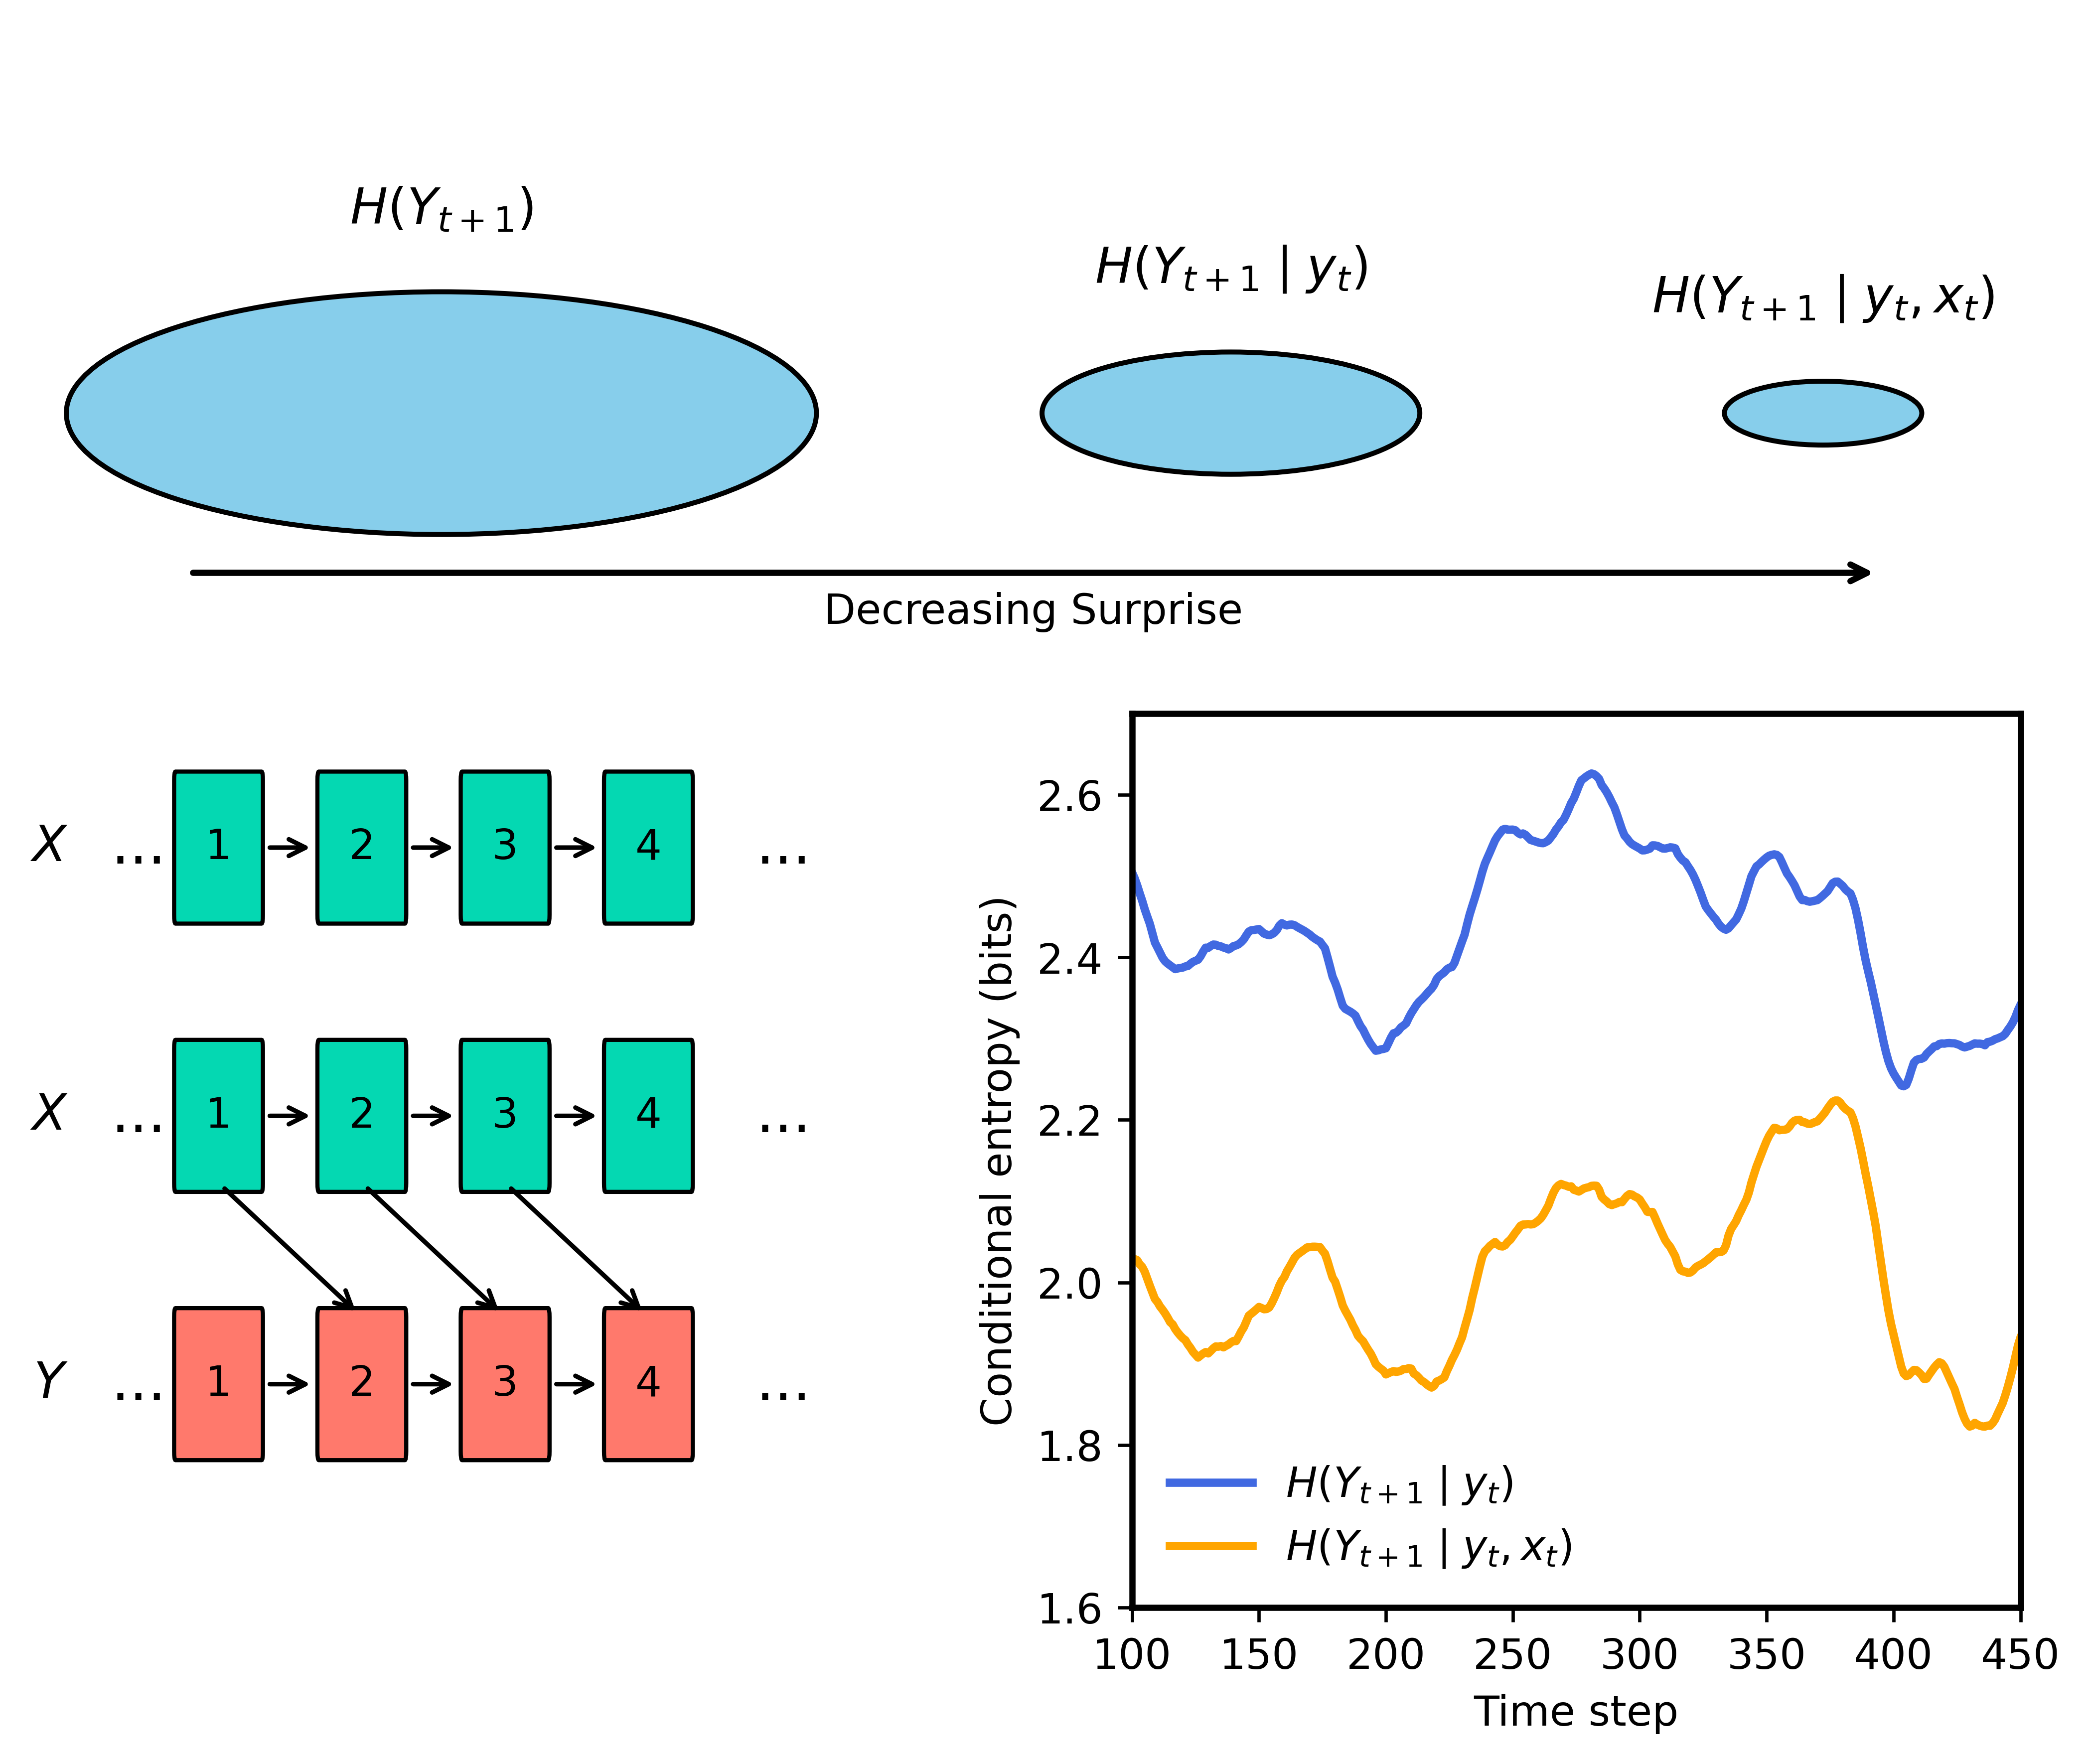

In [43]:
import matplotlib.patches as patches
import numpy as np
import matplotlib.pyplot as plt

# Set random seed for reproducibility
np.random.seed(0)

# 1. Simulate two variables where X drives Y
N = 1000
sigma_x = 1.0
sigma_y = 1.0

X = np.zeros(N)
Y = np.zeros(N)

for t in range(1, N):
    X[t] = 0.8 * X[t - 1] + np.random.normal(0, sigma_x)
    Y[t] = 0.5 * Y[t - 1] + 0.7 * X[t - 1] + np.random.normal(0, sigma_y)

# 2. Estimate sliding-window conditional entropies (in bits)
window = 50
times = np.arange(window, N - 1)

H_y, H_xy = [], []
for t in times:
    idx = slice(t - window, t)
    Y_past = Y[idx]
    Y_future = Y[idx.start + 1: idx.stop + 1]
    X_past = X[idx]

    A1 = np.vstack([np.ones_like(Y_past), Y_past]).T
    resid1 = Y_future - A1 @ np.linalg.lstsq(A1, Y_future, rcond=None)[0]
    H_y.append(0.5 * np.log2(2 * np.pi * np.e * np.var(resid1, ddof=1)))

    A2 = np.vstack([np.ones_like(Y_past), Y_past, X_past]).T
    resid2 = Y_future - A2 @ np.linalg.lstsq(A2, Y_future, rcond=None)[0]
    H_xy.append(0.5 * np.log2(2 * np.pi * np.e * np.var(resid2, ddof=1)))

H_y, H_xy = np.array(H_y), np.array(H_xy)
H_uncond = 0.5 * np.log2(2 * np.pi * np.e * np.var(Y[1:], ddof=1))

# smooth the H_y and H_xy with 20 pt rolling mean for better visualization, keep its length unchanged
H_y = np.convolve(H_y, np.ones(20) / 20, mode='same')
H_xy = np.convolve(H_xy, np.ones(20) / 20, mode='same')

# ---------------------------------------------------------------------
#  Build the figure
# ---------------------------------------------------------------------
fig = plt.figure(figsize=(7, 6), dpi=600)
gs = fig.add_gridspec(2, 2, height_ratios=[1, 1.4])

# -- TOP entropy circles ------------------------------------------------
ax_top = fig.add_subplot(gs[0, :])
ax_top.axis('off')
x_loc = [0.2, 0.6, 0.9]
vals = [H_uncond, H_y.mean(), H_xy.mean()]
labels = [r'$H(Y_{t+1})$',
          r'$H(Y_{t+1}\mid y_t)$',
          r'$H(Y_{t+1}\mid y_t,x_t)$']

r_min, r_max = 0.05, 0.19
v_min, v_max = min(vals), max(vals)
radii = [r_min + (v - v_min) / (v_max - v_min) * (r_max - r_min) if v_max != v_min else (r_min + r_max) / 2
         for v in vals]

for x, r, lab in zip(x_loc, radii, labels):
    ax_top.add_patch(plt.Circle((x, 0.4), r, fc='skyblue', ec='k', lw=1.2))
    ax_top.text(x, 0.45 + r + 0.04, lab, ha='center', va='bottom', fontsize=12)

# Horizontal arrow showing decreasing surprise
ax_top.annotate('', xy=(0.93, 0.15), xytext=(0.07, 0.15),
                arrowprops=dict(arrowstyle='->', lw=1.5))
ax_top.text(0.5, 0.12, 'Decreasing Surprise', ha='center', va='top', fontsize=10)
ax_top.set(xlim=(0, 1), ylim=(0, 1))

# -- BOTTOM-LEFT schematic time-series ----------------------------------
ax_ts = fig.add_subplot(gs[1, 0])
ax_ts.axis('off')
box_w, box_h = 0.6, 0.15
y1, y2, y3 = 0.85, 0.55, 0.25
xs = np.arange(0, 4)

# color_X = '#a6cee3'  # light blue
# color_Y = '#b2df8a'  # light green

color_X = '#04d8b2'  
color_Y = '#FF796C' 

def draw_row(y, fc, show_lr_arrows=True, label=None, numbers=False):
    for i, x in enumerate(xs):
        ax_ts.add_patch(patches.FancyBboxPatch(
            (x - box_w / 2, y - box_h / 2), box_w, box_h,
            boxstyle="round,pad=0.01", ec='k', fc=fc))
        if numbers:
            ax_ts.text(x, y, f'{i+1}', ha='center', va='center', fontsize=10)
        if show_lr_arrows and i < len(xs) - 1:
            ax_ts.annotate('', xy=(x + 1 - box_w / 2, y),
                           xytext=(x + box_w / 2, y),
                           arrowprops=dict(arrowstyle='->', lw=1.1))
    ax_ts.text(-0.75, y, '...', fontsize=14, va='center')
    ax_ts.text(3.75, y, '...', fontsize=14, va='center')
    if label:
        ax_ts.text(-1.05, y, label, ha='right', va='center', fontsize=12)

# Row 1: X with numbers
draw_row(y1, fc=color_X, show_lr_arrows=True, label=r'$X$', numbers=True)
# Row 2: X repeat
draw_row(y2, fc=color_X, show_lr_arrows=True, label=r'$X$', numbers=True)
# Row 3: Y aligned
draw_row(y3, fc=color_Y, show_lr_arrows=True, label=r'$Y$', numbers=True)

# Diagonal arrows X(row2) -> Y(row3) (+1 shift)
for x in xs:
    if x + 1 <= xs[-1]:
        ax_ts.annotate('', xy=(x + 1, y3 + box_h / 2),
                       xytext=(x, y2 - box_h / 2),
                       arrowprops=dict(arrowstyle='->', lw=1.1))

ax_ts.set(xlim=(-1.2, 5), ylim=(0, 1))

# -- BOTTOM-RIGHT entropy time-series -----------------------------------
ax_e = fig.add_subplot(gs[1, 1])
ax_e.plot(times, H_y, label=r'$H(Y_{t+1}\mid y_t)$', color='royalblue', lw=2)
ax_e.plot(times, H_xy, label=r'$H(Y_{t+1}\mid y_t,x_t)$', color='orange', lw=2)
ax_e.set_xlim(times[0]+50, times[0] + 400)
# set y-axis limits to 1.6 to 2.6
ax_e.set_ylim(1.6, 2.7)
ax_e.set_xlabel('Time step')
ax_e.set_ylabel('Conditional entropy (bits)')
ax_e.legend(frameon=False)
for spine in ['top', 'bottom', 'left', 'right']:
    ax_e.spines[spine].set_linewidth(1.5)

fig.tight_layout()
plt.show()


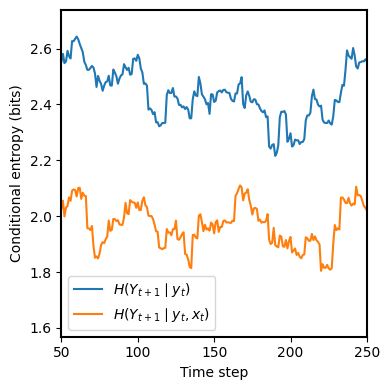

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# Set random seed for reproducibility
np.random.seed(0)

# 1. Simulate two variables where X drives Y
N = 1000
sigma_x = 1.0
sigma_y = 1.0

X = np.zeros(N)
Y = np.zeros(N)

for t in range(1, N):
    # X follows an AR(1) process
    X[t] = 0.8 * X[t - 1] + np.random.normal(0, sigma_x)
    # Y depends on its own past and on past X (so X "causes" Y)
    Y[t] = 0.5 * Y[t - 1] + 0.7 * X[t - 1] + np.random.normal(0, sigma_y)

# 2. Estimate sliding-window conditional entropies (in bits)
window = 50  # window size for local estimation
times = np.arange(window, N - 1)  # valid central time indices

H_y = []      # H(Y_{t+1} | y_t)   in bits
H_xy = []     # H(Y_{t+1} | y_t, x_t) in bits

for t in times:
    idx = slice(t - window, t)  # window [t-window, t-1]
    
    # Prepare data inside this window
    Y_past = Y[idx]
    Y_future = Y[idx.start + 1: idx.stop + 1]  # shifted by +1
    X_past = X[idx]
    
    # --- Model 1: Y_future ~ Y_past (simple linear regression) ---
    A1 = np.vstack([np.ones_like(Y_past), Y_past]).T
    coeff1, _, _, _ = np.linalg.lstsq(A1, Y_future, rcond=None)
    resid1 = Y_future - A1 @ coeff1
    var1 = np.var(resid1, ddof=1)
    H_y.append(0.5 * np.log2(2 * np.pi * np.e * var1))  # log base 2
    
    # --- Model 2: Y_future ~ Y_past + X_past ---
    A2 = np.vstack([np.ones_like(Y_past), Y_past, X_past]).T
    coeff2, _, _, _ = np.linalg.lstsq(A2, Y_future, rcond=None)
    resid2 = Y_future - A2 @ coeff2
    var2 = np.var(resid2, ddof=1)
    H_xy.append(0.5 * np.log2(2 * np.pi * np.e * var2))  # log base 2

# 3. Plot both conditional entropy series
plt.figure(figsize=(4, 4))
plt.plot(times, H_y, label=r'$H(Y_{t+1}\mid y_t)$')
plt.plot(times, H_xy, label=r'$H(Y_{t+1}\mid y_t,x_t)$')
plt.xlim(times[0], 250)
plt.xlabel('Time step')
plt.ylabel('Conditional entropy (bits)')
plt.legend()
# set the line width of top, bottom left and right spines
for spine in ['top', 'bottom', 'left', 'right']:
    plt.gca().spines[spine].set_linewidth(1.5)

plt.tight_layout()
plt.show()


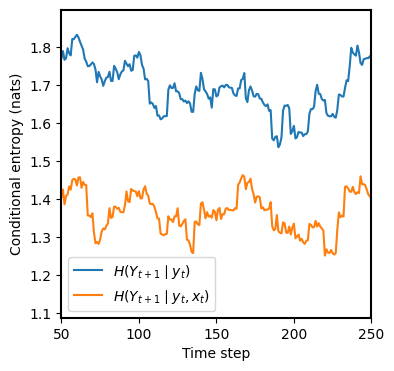

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# Set random seed for reproducibility
np.random.seed(0)

# 1. Simulate two variables where X drives Y
N = 1000
sigma_x = 1.0
sigma_y = 1.0

X = np.zeros(N)
Y = np.zeros(N)

for t in range(1, N):
    # X follows an AR(1) process
    X[t] = 0.8 * X[t - 1] + np.random.normal(0, sigma_x)
    # Y depends on its own past and on past X (so X "causes" Y)
    Y[t] = 0.5 * Y[t - 1] + 0.7 * X[t - 1] + np.random.normal(0, sigma_y)

# 2. Estimate sliding-window conditional entropies
window = 50  # window size for local estimation
times = np.arange(window, N - 1)  # valid central time indices

H_y = []      # H(Y_{t+1} | y_t)
H_xy = []     # H(Y_{t+1} | y_t, x_t)

for t in times:
    idx = slice(t - window, t)  # window [t-window, t-1]
    
    # Prepare data inside this window
    Y_past = Y[idx]
    Y_future = Y[idx.start + 1: idx.stop + 1]  # shifted by +1
    X_past = X[idx]
    
    # --- Model 1: Y_future ~ Y_past (simple linear regression) ---
    A1 = np.vstack([np.ones_like(Y_past), Y_past]).T
    coeff1, _, _, _ = np.linalg.lstsq(A1, Y_future, rcond=None)
    resid1 = Y_future - A1 @ coeff1
    var1 = np.var(resid1, ddof=1)
    H_y.append(0.5 * np.log(2 * np.pi * np.e * var1))
    
    # --- Model 2: Y_future ~ Y_past + X_past ---
    A2 = np.vstack([np.ones_like(Y_past), Y_past, X_past]).T
    coeff2, _, _, _ = np.linalg.lstsq(A2, Y_future, rcond=None)
    resid2 = Y_future - A2 @ coeff2
    var2 = np.var(resid2, ddof=1)
    H_xy.append(0.5 * np.log(2 * np.pi * np.e * var2))

# # 3. Plot both conditional entropy series
# plt.figure(figsize=(10, 4))
# plt.plot(times, H_y, label=r'$H(Y_{t+1}\mid y_t)$')
# plt.plot(times, H_xy, label=r'$H(Y_{t+1}\mid y_t,x_t)$')
# plt.xlabel('Time step')
# plt.ylabel('Conditional entropy (nats)')
# plt.title('Sliding-window estimates of conditional entropy\n(window = 50 samples)')
# plt.legend()
# plt.tight_layout()
# plt.show()


# 3. Plot both conditional entropy series
plt.figure(figsize=(4, 4))
plt.plot(times, H_y, label=r'$H(Y_{t+1}\mid y_t)$')
plt.plot(times, H_xy, label=r'$H(Y_{t+1}\mid y_t,x_t)$')
# set xlim
plt.xlim(times[0], 250)
plt.xlabel('Time step')
plt.ylabel('Conditional entropy (nats)')
# plt.title('Sliding-window estimates of conditional entropy\n(window = 50 samples)')
plt.legend()
# set the line width of top, bottom left and right spines
plt.gca().spines['top'].set_linewidth(1.5)
plt.gca().spines['bottom'].set_linewidth(1.5)
plt.gca().spines['left'].set_linewidth(1.5)
plt.gca().spines['right'].set_linewidth(1.5)


# plt.tight_layout()
plt.show()
